## TF-Faster-RCNN-RPN

----------------------
I will implement RPN network in this notebook. 


#### Objective of this notebook 
1. Trian a rpn for object localization 


### Section list

1. Define a generator that return (1, height, width, 3), (1, nb_boxes, 4), (1, nb_boxes, 1)
2. Define the conv. layers 
3. Define the rpn layers 
4. Define the loss tensors
5. build network 
6. Train the network 

### Improt dependency  

In [1]:
from tensorflow.contrib import layers
from tensorflow.contrib.framework.python.ops import arg_scope
from tensorflow.contrib.layers.python.layers import layers as layers_lib
from tensorflow.contrib.layers.python.layers import regularizers
from tensorflow.contrib.layers.python.layers import utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import variable_scope
import tensorflow.contrib.slim as slim
import tensorflow as tf
import os
import time
from tqdm import tqdm
import datetime

from scipy.misc import imresize

from math import floor,exp, log
import pprint

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pylab as plt
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import sklearn
import pickle
%matplotlib inline

### Define the global varables

In [2]:
anchor_box_scales = [128, 256, 512]
anchor_box_ratio = [[1,1],[1,2],[2,1]]
nb_anchors = len(anchor_box_scales) * len(anchor_box_ratio)
EPOCHES = 10

dataSets = ['VOC2012']

PRINT_TIME = False
GENERATE_GROUND_TRUTH = False
UNIT_TEST = True
DEBUG = False


TEST_FULL_IMG = np.array([mpimg.imread("./test1.jpg")])
print(TEST_FULL_IMG.shape)
print(TEST_FULL_IMG.shape[1]/4, TEST_FULL_IMG.shape[2]/4)

(1, 720, 1280, 3)
180.0 320.0


In [3]:
import sys
from queue import Queue
from threading import Thread


class Worker(Thread):
    """ Thread executing tasks from a given tasks queue """
    def __init__(self, tasks):
        Thread.__init__(self)
        self.tasks = tasks
        self.daemon = True
        self.start()

    def run(self):
        while True:
            func, args, kargs = self.tasks.get()
            try:
                func(*args, **kargs)
            except Exception as e:
                # An exception happened in this thread
                print(e)
            finally:
                # Mark this task as done, whether an exception happened or not
                self.tasks.task_done()


class ThreadPool:
    """ Pool of threads consuming tasks from a queue """
    def __init__(self, num_threads):
        self.tasks = Queue(num_threads)
        for _ in range(num_threads):
            Worker(self.tasks)

    def add_task(self, func, *args, **kargs):
        """ Add a task to the queue """
        self.tasks.put((func, args, kargs))

    def map(self, func, args_list):
        """ Add a list of tasks to the queue """
        for args in args_list:
            self.add_task(func, args)

    def wait_completion(self):
        """ Wait for completion of all the tasks in the queue """
        self.tasks.join()


## Define the conv. layers

---------

I will define vgg16 conv layers. 

Vgg 16 used in this project, it use the pretrain network from imageNet. The network defined until conv5.

The vgg16 function accept iamge input and otput the nets tensor and the enpoints.

We use conv5 as our feature map layer, which will port to rpn and rcnn.

In [4]:
# Define the vgg16 layers
def vgg_16(inputs,  scope='vgg_16'):
    with tf.variable_scope(scope, 'vgg_16', [inputs]) as sc:
        end_points_collection = sc.name + '_end_points'

        # Collect outputs for conv2d, fully_connected and max_pool2d.
        with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.max_pool2d], outputs_collections=end_points_collection):
            net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
#             net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
#             net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')

            # Convert end_points_collection into a end_point dict.
            end_points = slim.utils.convert_collection_to_dict(end_points_collection)
        
    return net, end_points

## Define the rpn layers


we will define the RPN network. 

It have few steps. 
1. Define the conv layers of rpn.
2. Mapping rpn to bbox

In [5]:

def rpn_cls_shape_func(in_list):
    cls = in_list
    return np.array([cls.shape[0], cls.shape[1],cls.shape[2],cls.shape[3],1]).astype(np.int32)

def rpn_regr_shape_func(in_list):
    regr = in_list
    return np.array([regr.shape[0], regr.shape[1],regr.shape[2],regr.shape[3]/4,4]).astype(np.int32)

def rpn(net, num_anchors=9, scope="rpn"):
    with tf.variable_scope(scope, 'rpn', [net]) as sc:
        end_points_collection = sc.name + '_end_points'
        
        with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.max_pool2d], 
                            outputs_collections=end_points_collection, 
#                             activation_fn=tf.nn.relu,
                            weights_initializer=tf.truncated_normal_initializer(stddev=0.01)):
            
            net = slim.conv2d(net, 512, [3, 1], scope='rpn_conv_3x3', padding='SAME')
            
            rpn_class = slim.conv2d(net, num_anchors, [1, 1], scope='rpn_class')
            rpn_class = tf.nn.relu(rpn_class)
            rpn_cls_shape = tf.py_func(rpn_cls_shape_func, [rpn_class], tf.int32, name="rpn_cls_shape")
            rpn_class = tf.reshape(rpn_class, rpn_cls_shape)
            
            rpn_regr = slim.conv2d(net, num_anchors*4, [1, 1], scope='rpn_regr')
            rpn_regr = tf.nn.relu(rpn_regr) 
#             rpn_regr = tf.clip_by_value(rpn_regr, -999, 999)
            rpn_regr_shape = tf.py_func(rpn_regr_shape_func, [rpn_regr], tf.int32, name="rpn_regr_shape")
            rpn_regr = tf.reshape(rpn_regr, rpn_regr_shape)

            # Convert end_points_collection into a end_point dict.
            end_points = slim.utils.convert_collection_to_dict(end_points_collection)
        
    return rpn_class, rpn_regr, end_points

#### Define proposal layer 

1. The network will tranform the network result to the x,y,w,h 
2. Then it will transfrom to x1,y1,x2,y2 format 
3. take top N proposals eg: 6000
4. Non maximum supreesion
5. take top N proposal 300

---------

In [6]:
def transform_txtytwth_to_xywh(rpn_regr, anchor_box):
    '''apply clipping box'''
    dx = rpn_regr[:,0]
    dy = rpn_regr[:,1]
    dw = rpn_regr[:,2]
    dh = rpn_regr[:,3]
    
    ax = anchor_box[:,0]
    ay = anchor_box[:,1]
    aw = anchor_box[:,2]
    ah = anchor_box[:,3]
    
    
    res = np.zeros(rpn_regr.shape)
    res[:,0] = dx * aw + ax
    res[:,1] = dy * ah + ay
    res[:,2] = np.exp(dw) * aw
    res[:,3] = np.exp(dh) * ah
    
    return res

def transform_xywh_to_xyxy(xywh):
    '''transform the format '''
    res = np.zeros(xywh.shape)
    cx = xywh[:,0]
    cy = xywh[:,1]
    w  = xywh[:,2]
    h  = xywh[:,3]
    
    res[:,0] = cx - w/2
    res[:,1] = cy - h/2
    res[:,2] = res[:,0] + w
    res[:,3] = res[:,1] + h
    
    return res

def combine_into_one_list(xyxy, cls):
    '''combine cls and regr res into one list, which faster for calculate the res'''
    resized_regr = np.reshape(xyxy, [-1, 4])
    resized_cls = np.reshape(cls,  [-1, 1])
    return np.concatenate([resized_regr, resized_cls], axis=1)

def sort_desc(array):
    ''' assume (x,y,x,y,s) '''
    return  array[(array[:,-1]*-1).argsort()] 


def select_top_6000(bbox):
    '''select 6000 bbox'''
    top6000 = sort_desc(bbox)[0:6000,:]
    return top6000


def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

def apply_nms(bboxes):
    ''' apply nms '''
    idx = py_cpu_nms(bboxes, 0.7)
    return bboxes[idx]

def select_top_300(bboxes):
    ''' select first 300 bbox'''
    top300 = sort_desc(bboxes)[0:300,:]
    return top300

def checkHaveInf(nparray):
    isInf = np.isinf(nparray)
    isTrue = (isInf == True)
    if len(isInf[isTrue]) >0:
        print(nparray)
        print(isTrue)

def rpn_proposal_layer_py_func(anchors, rpn_regr, rpn_cls):
    '''  python fucntion in tf, it should return bbox list '''
    
    rpn_regr = np.reshape(rpn_regr,[-1,4])
    rpn_cls = np.reshape(rpn_cls,[-1,1])
    anchors = np.reshape(anchors,[-1,4])
    
#     print("check anchors")
#     checkHaveInf(anchors)
#     print("check rpn_cls")
#     checkHaveInf(rpn_cls)
#     print("check rpn_regr")
    checkHaveInf(rpn_regr)
    
    xywh = transform_txtytwth_to_xywh(rpn_regr, anchors)
    
    xyxy = transform_xywh_to_xyxy(xywh)
#     print(xyxy)
    
    box_list = combine_into_one_list(xyxy, rpn_cls)
#     print(box_list)
#     print("np.isfinite(box_list).shape",np.isfinite(box_list).shape)
#     print(np.isfinite(box_list))
#     print("box_list",box_list)
    
    top6000 = select_top_6000(box_list)
#     print(top6000)
    
    nms_res = apply_nms(top6000)
#     print(nms_res)
    
    return select_top_300(nms_res).astype(np.float32)

def rpn_proposal_layer(anchors, rpn_regr, rpn_cls):
    ''' used when build the network, should return bbox only '''
    tensor_input = [anchors, rpn_regr, rpn_cls]
    rpn_proposal = tf.py_func(rpn_proposal_layer_py_func, tensor_input, [tf.float32], name="rpn_proposal")
    return rpn_proposal

In [7]:
## Test 
# rows = 10

# test_arr = np.random.randn(rows, 5) *10
# print(test_arr)
# res = test_arr[(test_arr[:,-1]*-1).argsort()][0:6000, :]


# # res = np.sort(test_arr.view('f4,f4,f4,f4,f4'), order=['f1'], axis=0).view(np.int)

# print(res)



#### Generate ground truth

In [8]:

def create_generate_anchors( anchor_box_scales = [128, 256, 512],   anchor_box_ratio = [[1,1],[1,2],[2,1]] ):
    def generate_anchors(featureMap, img):
        '''
            Not batch is return, which can save memory in run time 
        '''
#         print(featureMap.shape, img.shape)
#       expect input have same dimensions
#         assert(len(featureMap.shape) == len(img.shape))
#       expect input have 4 deminsions
        assert(len(featureMap.shape) > 4)
        assert(len(img.shape) >= 4)
#         print("img.shape[1]",img.shape[1], "featureMap.shape[1]",featureMap.shape[1])
        start = time.time()
        
        stepSize = int(img.shape[1]/featureMap.shape[1])
        imgWidth = img.shape[2]
        imgheight = img.shape[1]
        
        anchors = []
        for scale in anchor_box_scales:
            for ratio in anchor_box_ratio:
                anchors.append([ratio[0]*scale,ratio[1]*scale])
        anchors = np.array(anchors)

        bbox = np.zeros((featureMap.shape[1], featureMap.shape[2], len(anchors), 4))
        
        if(featureMap.shape[2] != int(imgWidth/4) ):
            print("---------- featureMap.shape[2]",featureMap.shape[2],"imgWidth/4",imgWidth/4, "int(imgWidth/4)",int(imgWidth/4))

#         base on the feature map that input to this function 
        x = range(int(stepSize/2), featureMap.shape[2]*stepSize, stepSize)
        y = range(int(stepSize/2), featureMap.shape[1]*stepSize, stepSize)

        xv, yv= np.meshgrid(x, y)

        for anchorIdx, width, height in zip(range(len(anchors)), anchors[:,0], anchors[:,1]):
            bbox[:,:,anchorIdx,0] = xv
            bbox[:,:,anchorIdx,1] = yv
            bbox[:,:,anchorIdx,2].fill(width)
            bbox[:,:,anchorIdx,3].fill(height)
        bbox = bbox.astype(np.int32)
        
        if(PRINT_TIME):
            print("generate_anchors use",time.time() - start,"s")

        return bbox
    return generate_anchors


In [9]:
from string import Template 

def test_generate_anchors():
    # get the fucntion who generate anchors 
    get_anchors = create_generate_anchors()
    
#     1920x1080 => 135x240
    img = np.zeros([1,40,100,3])
    featureMap = np.zeros([1,10,25,9,4])
    # generate a anchors 
    anchors = get_anchors(featureMap, img)
    
    print("anchors.shape",anchors.shape)
    
    assert(featureMap.shape[1] == anchors.shape[0])    
    assert(featureMap.shape[2] == anchors.shape[1])  
    
#     print(anchors[5,5])
    assert(np.array_equal(anchors[0,0,0], [2,2,128,128]))
    assert(np.array_equal(anchors[0,0,8], [2,2,1024,512]))
    assert(np.array_equal(anchors[6,6,8], [26,26,1024,512]))    

if UNIT_TEST:
    test_generate_anchors()

anchors.shape (10, 25, 9, 4)


In [10]:

def union(au, bu):
    x = min(au[0], bu[0])
    y = min(au[1], bu[1])
    w = max(au[2], bu[2]) - x
    h = max(au[3], bu[3]) - y
    return x, y, w, h

def intersection(ai, bi):
    x = max(ai[0], bi[0])
    y = max(ai[1], bi[1])
    w = min(ai[2], bi[2]) - x
    h = min(ai[3], bi[3]) - y
    if w < 0 or h < 0:
        return 0, 0, 0, 0
    return x, y, w, h

def iou(a_, b_):
#   a, b should be x,y,w,h format
    # a and b should be (x1,y1,x2,y2)
    x1 = a_[0] - a_[2]/2
    y1 = a_[1] - a_[3]/2
    a = [x1, y1, x1+a_[2], y1 + a_[3]]
    
    bx1 = b_[0] - b_[2]/2
    by1 = b_[1] - b_[3]/2
    b = [bx1, by1, bx1+b_[2], by1 + b_[3]]
    
    if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
        return 0.0

    i = intersection(a, b)
    u = union(a, b)

    area_i = i[2] * i[3]
    area_u = u[2] * u[3]
    return float(area_i) / float(area_u)

#### Test IoU

In [11]:
def testIoU():
    box_a = [50,50,50,50]
    box_b = [50,55,50,40]
    v = iou(box_a, box_b)
#     print(v)
    assert( v> 0.7)

if UNIT_TEST:
    testIoU()

In [12]:
import threading

def cal_parameterizations_bbox(ax, ay, aw, ah, bx, by, bw, bh):
    return [(ax-bx)/bw, (ay-by)/bh, log(aw/bw), log(ah/bh)]


def create_rpn_ground_truth(anchors, bboxes, bboxes_cls):
    '''
        Since it is training one img is accepted 
        input shape = (1,None,4) in x,y,w,h
        return anchorbox with t_x, t_y, t_w, t_h and anchorBoxLabel with -1 neg, 1 is pos, 0 is nth
    '''
    assert(len(bboxes.shape) == 3)
    assert(len(bboxes_cls.shape) == 3)
    
    start = time.time()
    
    regr_y = np.zeros(anchors.shape)
    cls_shape = np.array(anchors.shape)
    cls_shape[-1] = 1
    cls_y = np.zeros(cls_shape)
    
#     print("cls_shape",cls_shape)
#     print("anchors.shape",anchors.shape)
#     print("bboxes.shape",bboxes.shape)
#     print("bboxes_cls.shape",bboxes_cls.shape)
    
    highest_iou = (0.,[])
    debugeMsg = 0
    
    for box, box_class in zip(bboxes[0],bboxes_cls[0]):
        # skip bg class
        if box_class == 0:
            continue
            
        pos_list = []
        neg_list = []
        
#         lock = threading.Lock()
        
#         def compareIou(arg):
#             nonlocal highest_iou
#             nonlocal anchors
#             nonlocal regr_y
#             nonlocal lock
            
#             y,x,a = arg
#             anchor = anchors[y,x,a]
#             regr   = regr_y[y,x,a]

#             # cal the iou 
#             iou_v = iou(anchor, box)
#             debugeMsg = iou_v
            
#             with lock:
#                 if iou_v > highest_iou[0]:
#                     highest_iou = (iou_v,[y,x,a])

#                 # if iou <= 0.3
#         #                        add to neg list
#                 if iou_v <= 0.3:
#         #                         if(abs(anchor[0]-box[0]) < 50 and abs(anchor[1]-box[1]) < 50):
#         #                             print("anchor, box, iou_v",anchor, box, iou_v)
#                     neg_list.append([y,x,a])
#                 # if iou >= 0.7
#         #                        add to pos list
#                 elif iou_v >= 0.7:
#                     pos_list.append([y,x,a])
        
#         print("start cal iou")
#         start_cal_iou = time.time()
        
#         args = []
#         for y in range(anchors.shape[0]):
#             for x in range(anchors.shape[1]):
#                 for a in range(anchors.shape[2]):
#                     args.append( (y,x,a) )
        
#         pool = ThreadPool(4)
#         pool.map(compareIou,args)
#         pool.wait_completion()
        
#         print("cal a bbox iou done")        
#         if(PRINT_TIME):
#             print("cal_iou use new ",time.time() - start_cal_iou,"s")
        
        
        
        start_cal_iou = time.time()
        for y in range(anchors.shape[0]):
#             start_cal_iou_row = time.time()
            for x in range(anchors.shape[1]):
                for a in range(anchors.shape[2]):
                    
                    anchor = anchors[y,x,a]
                    regr   = regr_y[y,x,a]
#                     cls    = cls_y[y,x,a]
                    
                    # cal the iou 
                    iou_v = iou(anchor, box)
                    debugeMsg = iou_v
                    
                    if iou_v > highest_iou[0]:
                        highest_iou = (iou_v,[y,x,a])
                        
                    # if iou <= 0.3
#                        add to neg list
                    if iou_v <= 0.3:
#                         if(abs(anchor[0]-box[0]) < 50 and abs(anchor[1]-box[1]) < 50):
#                             print("anchor, box, iou_v",anchor, box, iou_v)
                        neg_list.append([y,x,a])
                    # if iou >= 0.7
#                        add to pos list
                    elif iou_v >= 0.7:
                        pos_list.append([y,x,a])
#             if(PRINT_TIME):
#                 print("cal_iou_row use",time.time() - start_cal_iou_row,"s")
        if(PRINT_TIME):
            print("cal_iou use old version",time.time() - start_cal_iou,"s")
                                
                    
#         print("highest_iou",highest_iou)
#         print("len(pos_list)",len(pos_list))
#         print("len(neg_list)",len(neg_list))
#         print("box",box)
        
        
        if len(pos_list) == 0:
            pos_list.append(highest_iou[1])
            
            
        pos_list = np.array(pos_list)
        neg_list = np.array(neg_list)
        
        
#       filter max 256 or balance the smapling in ratio 1:1       
        smaple_size = min(len(pos_list), len(neg_list), 256)
    
#         print("min(len(pos_list), len(neg_list), 256)", len(pos_list), len(neg_list), 256)
        idx_pos = np.random.randint(len(pos_list), size=smaple_size)
        idx_neg = np.random.randint(len(neg_list), size=smaple_size)
            
        if DEBUG:
            print("len(idx_pos)",len(idx_pos))
            print("len(idx_neg)",len(idx_neg))

#       label the cls and cal. the parameterizations 
        selected_pos = pos_list[idx_pos]
#         if len(selected_pos) == 1 or highest_iou[0] < 0.1:
#             print("selected_pos ==1", selected_pos)
#             print("idx_pos",idx_pos)
#             print("pos_list",pos_list)
#             print(highest_iou)
#             print(debugeMsg)
#             print(box)
        if DEBUG:
            print("selected_pos",selected_pos)
            print("idx_pos",idx_pos)
        for r_pos in selected_pos:
            y = r_pos[0]
            x = r_pos[1]
            a = r_pos[2]
            anchor = anchors[y,x,a]
            regr_y[y,x,a] = cal_parameterizations_bbox(box[0], box[1], box[2], box[3], anchor[0], anchor[1], anchor[2], anchor[3])
            cls_y[y,x,a] = 1
            if DEBUG:
                print("cls_y in ",y,x,a,"set to 1")
        
        selected_neg = neg_list[idx_neg]
        if DEBUG:
            print("selected_neg",selected_neg)
        for r_neg in selected_neg:
            y = r_neg[0]
            x = r_neg[1]
            a = r_neg[2]
            anchor = anchors[y,x,a]
            regr_y[y,x,a] = cal_parameterizations_bbox(box[0], box[1], box[2], box[3], anchor[0], anchor[1], anchor[2], anchor[3])
            cls_y[y,x,a] = -1
            if DEBUG:
                print("cls_y in ",y,x,a,"set to -1")
        
#   select highest iou if none in the pos list            
#     print(cls_y)            
    if(PRINT_TIME):
        print("create_rpn_ground_truth use",time.time() - start,"s")
        
    return regr_y.astype(np.float32), cls_y.astype(np.float32)
 
def cls_ground_truth(regr, cls):
    return cls

def regr_ground_truth(regr, cls):
    return regr  

In [36]:
def test_create_rpn_ground_truth():
    # get the fucntion who generate anchors 
    get_anchors = create_generate_anchors()
    
#     1920x1080 => 135x240
    img = np.zeros([1,int(1080/2),int(1920/2),3])
    featureMap = np.zeros([1,int(1080/4/2),int(1920/4/2),9,4])
    # generate a anchors 
    anchors = get_anchors(featureMap, img) 
    
    boxes = [[[450,450,450,450]]]
    boxes_cls = [[[1]]]
    
#     anchors, bboxes, bboxes_cls
    truth_regr, truth_cls = create_rpn_ground_truth(anchors, np.array(boxes), np.array(boxes_cls))
    return truth_regr, truth_cls

if UNIT_TEST:
    DEBUG = True
    regr, cls = test_create_rpn_ground_truth()
    DEBUG = False

len(idx_pos) 256
len(idx_neg) 256
selected_pos [[118 111   6]
 [114 117   6]
 [109 112   6]
 [112 120   6]
 [107 121   6]
 [109 101   6]
 [111 117   6]
 [111 105   6]
 [117 100   6]
 [115 100   6]
 [103 110   6]
 [101 117   6]
 [121 115   6]
 [105 101   6]
 [115 118   6]
 [108 103   6]
 [104 115   6]
 [120  99   6]
 [114 125   6]
 [117 107   6]
 [116 100   6]
 [106 122   6]
 [109 109   6]
 [122 120   6]
 [114 112   6]
 [124 111   6]
 [120 116   6]
 [120 115   6]
 [103 117   6]
 [118 124   6]
 [109 118   6]
 [108 111   6]
 [122 110   6]
 [110 104   6]
 [111 105   6]
 [122 110   6]
 [100 112   6]
 [120 109   6]
 [115 103   6]
 [110 110   6]
 [111 124   6]
 [101 111   6]
 [106 109   6]
 [120 117   6]
 [118 104   6]
 [111 120   6]
 [118 108   6]
 [124 110   6]
 [ 99 112   6]
 [ 99 116   6]
 [109 108   6]
 [117 111   6]
 [106  99   6]
 [102 103   6]
 [122 102   6]
 [107 118   6]
 [125 118   6]
 [115 105   6]
 [109 116   6]
 [121 123   6]
 [108 103   6]
 [100 108   6]
 [106 113   6]
 [111 12

## Define the loss tensors


In [14]:
lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0


esilon = 1e-4


def rpn_regr_loss(y_pred, y_true_regr, y_true_cls):
    
    epsilon_tf = tf.constant(esilon, dtype=tf.float32, name="epsilon_tf")
    
#     where = 
#     idx = tf.where(where)
#     tf.gather(params, idx)
    
    pos_anchors = tf.multiply(y_true_cls, tf.cast(tf.equal(y_true_cls, 1), tf.float32)) 
    
    x = tf.subtract(y_pred, y_true_regr)
    x_abs = tf.abs(x)
    l1_sign = tf.cast(tf.less(x_abs, 1.0), tf.float32, name="x_bool")
    l1_1 = tf.multiply(tf.multiply(x, x), 0.5 )
    l1_2 = tf.subtract(x_abs, 0.5 )
    li_res = tf.add(tf.multiply(l1_1, l1_sign), tf.multiply(l1_2, tf.abs(tf.subtract(l1_sign, 1.0)))  )
    
    x_smooth_l1_pos_only = tf.multiply(pos_anchors, li_res) 
    return lambda_rpn_regr * x_smooth_l1_pos_only / tf.reduce_sum(epsilon_tf + pos_anchors)
    
def rpn_class_loss(y_pred, y_true_cls):    
    non_zeros = tf.cast(tf.not_equal(y_true_cls, 0), tf.float32)
    y_true_cls_selected = tf.multiply(y_true_cls, non_zeros) 
    y_pred_selected = tf.multiply(y_pred, non_zeros) 
    
    epsilon_tf = tf.constant(esilon, dtype=tf.float32, name="epsilon_tf")
    return tf.nn.softmax_cross_entropy_with_logits( labels=y_true_cls_selected,  logits=y_pred_selected, name="softmax_cross_entropy_with_logits")
#     x = y_true_cls * tf.binary_crossentropy(y_pred, y_true_cls)
#     return lambda_rpn_class * tf.sum(x) / tf.reduce_sum(epsilon_tf + y_true_cls)

In [15]:
### test rpn_regr_loss
def test_rpn_regr_loss():
    print("unit test on rpn_regr_loss")
    y_pred_arr = np.array([[1,1,1,1],[1,1,1,1]])
    y_pred = tf.constant(y_pred_arr, dtype=tf.float32, name="y_pred")
    y_true_regr_arr = np.array([[2,2,2,2],[2,2,2,2]])
    y_true_regr = tf.constant(y_true_regr_arr, dtype=tf.float32, name="y_true_regr")
    y_true_cls_arr =np.array([[1],[0]])
    y_true_cls = tf.constant(y_true_cls_arr, dtype=tf.float32, name="y_true_cls")
    
    regr_loss = rpn_regr_loss(y_pred,y_true_regr,y_true_cls)
    
    print("build graph")
    with tf.Session() as sess:
        loss = sess.run([regr_loss])
        print(loss)
        print("ensure it return a list")
        assert(len(loss) == 1)
        assert(np.sum(loss[0][0]) > 0)
        assert(np.sum(loss[0][1]) == 0)
        
if UNIT_TEST:
    test_rpn_regr_loss()

unit test on rpn_regr_loss
build graph
[array([[ 0.49990001,  0.49990001,  0.49990001,  0.49990001],
       [ 0.        ,  0.        ,  0.        ,  0.        ]], dtype=float32)]
ensure it return a list


## Define generator

We use VOC datasets in this implmentation.

### Get annotations 

In [16]:

def get_voc_data(input_path):
    all_imgs = []

    classes_count = {}

    class_mappingNameToId = {}
    class_mappingIdToName = {}

    visualise = False

    data_paths = [os.path.join(input_path, s) for s in dataSets]

    print ('Parsing annotation files')

    for data_path in data_paths:

        annot_path = os.path.join(data_path, 'Annotations')
        imgs_path = os.path.join(data_path, 'JPEGImages')
        imgsets_path_trainval = os.path.join(data_path, 'ImageSets',
                'Main', 'trainval.txt')

# ........imgsets_path_test = os.path.join(data_path, 'ImageSets','Main','test.txt')

        trainval_files = []
        test_files = []
        try:
            with open(imgsets_path_trainval) as f:
                for line in f:
                    trainval_files.append(line.strip() + '.jpg')
        except Exception as e:

# ............with open(imgsets_path_test) as f:
# ................for line in f:
# ....................test_files.append(line.strip() + '.jpg')

            print (e)

        annots = [os.path.join(annot_path, s) for s in
                  os.listdir(annot_path)]
        idx = 0
        for annot in annots:
            try:
                idx += 1

                et = ET.parse(annot)
                element = et.getroot()

                element_objs = element.findall('object')
                element_filename = element.find('filename').text
                element_width = int(element.find('size').find('width'
                                    ).text)
                element_height = int(element.find('size').find('height'
                        ).text)

                if len(element_objs) > 0:
                    annotation_data = {
                        'filepath': os.path.join(imgs_path,
                                element_filename),
                        'width': element_width,
                        'height': element_height,
                        'bboxes': [],
                        }

                    if element_filename in trainval_files:
                        annotation_data['imageset'] = 'trainval'
                    elif element_filename in test_files:
                        annotation_data['imageset'] = 'test'
                    else:
                        annotation_data['imageset'] = 'trainval'

                for element_obj in element_objs:
                    class_name = element_obj.find('name').text
                    if class_name not in classes_count:
                        classes_count[class_name] = 1
                    else:
                        classes_count[class_name] += 1

                    if class_name not in class_mappingNameToId:
                        class_mappingNameToId[class_name] = \
                            len(class_mappingNameToId)
                        class_mappingIdToName[len(class_mappingNameToId)
                                - 1] = class_name

                    obj_bbox = element_obj.find('bndbox')
                    x1 = int(round(float(obj_bbox.find('xmin').text)))
                    y1 = int(round(float(obj_bbox.find('ymin').text)))
                    x2 = int(round(float(obj_bbox.find('xmax').text)))
                    y2 = int(round(float(obj_bbox.find('ymax').text)))
                    w = x2 - x1
                    h = y2 - y1
                    x = int(round(x1 + w / 2))
                    y = int(round(y1 + h / 2))
                    difficulty = int(element_obj.find('difficult'
                            ).text) == 1
                    annotation_data['bboxes'].append({
                        'class': class_name,
                        'x1': x1,
                        'x2': x2,
                        'y1': y1,
                        'y2': y2,
                        'difficult': difficulty,
                        'x': x,
                        'y': y,
                        'w': w,
                        'h': h,
                        })
                all_imgs.append(annotation_data)

                if visualise:
                    img = cv2.imread(annotation_data['filepath'])
                    for bbox in annotation_data['bboxes']:
                        cv2.rectangle(img, (bbox['x1'], bbox['y1']),
                                (bbox['x2'], bbox['y2']), (0, 0, 255))
                    cv2.imshow('img', img)
                    cv2.waitKey(0)
            except Exception as  e:

                print (e)
                continue

        # make if no bg in the className make bg class

        if 'bg' not in classes_count:
            print ('bg not in class')
            
            class0Name = class_mappingIdToName[0]
            class0NewId = len(class_mappingNameToId)
            
            
            classes_count['bg'] = 0
            class_mappingNameToId['bg'] = 0 
            class_mappingIdToName[0] = 'bg'
            
            class_mappingNameToId[class0Name] = class0NewId
            class_mappingIdToName[len(class_mappingNameToId)-1] = class0Name
            
            
        else:
            print ('bg in class')
            # if there are a bg class make it first index
            bgOldId = class_mappingNameToId['bg']
            #switch id bg to 0id class
            if bgOldId != 0 :
                class0Name = class_mappingIdToName[0]
                class0NewId = bgOldId
                
                class_mappingIdToName[0] = 'bg'
                class_mappingNameToId['bg'] = 0
                
                class_mappingIdToName[class0NewId] = class0Name
                class_mappingNameToId[class0Name] = class0NewId
            
    return (all_imgs, classes_count, class_mappingNameToId, class_mappingIdToName)

### Define pre-process ground truth 


Since generate ground it might take 16s for generate the ground truth in python, thus a better way to speed up the training is preprocess the datasets with ground truth. Generater load the ground truth when it is needed.

---------------------


In [17]:
import time
from multiprocessing import Pool

class Data_source:
    def __init__(self):
        all_imgs, classes_count, class_mappingNameToId, class_mappingIdToName = get_voc_data("./data")
        self.all_imgs = all_imgs
        self.classes_count = classes_count
        self.class_mappingNameToId = class_mappingNameToId
        self.class_mappingIdToName = class_mappingIdToName
        
    def get_classId(self, class_name):
        return self.class_mappingNameToId[class_name]
    
    def get_total_imgs(self):
        return len(self.all_imgs)
    
    def get_generator(self):
        '''
            generator use in training
            imgs 
            x,y,w,h
            x1,y1,x2,y2
            class
            
            return (1, height, width, 3), (1, nb_boxes, 4), (1, nb_boxes, 4), (1, nb_boxes, 1)
        '''
        records = sklearn.utils.shuffle(self.all_imgs)
        for record in records:
            img = mpimg.imread(record["filepath"])
            img = img/255 - 0.5
            
            #load ground truth 
            with open(record["filepath"]+'.pkl', 'rb') as handle:
            
                rpn_cls_ground_truth = pickle.load(handle)
                rpn_regr_ground_truth = pickle.load(handle)
#                 print(rpn_cls_ground_truth)
            
            
            box_xywh = []
            box_xyxy = []
            box_class = []
            
            for box in record["bboxes"]:
                box_xywh.append([box["x"], box["y"], box["w"], box["h"]])
                box_xyxy.append([box["x1"], box["y1"], box["x2"], box["y2"]])
                name = self.get_classId(box["class"])
                box_class.append([name])
        
            yield np.array([img]), np.array([box_xywh]), np.array([box_xyxy]), np.array([box_class]), rpn_cls_ground_truth ,rpn_regr_ground_truth
            
    def get_generate_ground_truth_args(self):
        records = sklearn.utils.shuffle(self.all_imgs)
        res = []
        
        for record in records:
#             img = mpimg.imread(record["filepath"])
            
            
            box_xywh = []
            box_xyxy = []
            box_class = []
            
            for box in record["bboxes"]:
                box_xywh.append([box["x"], box["y"], box["w"], box["h"]])
                box_xyxy.append([box["x1"], box["y1"], box["x2"], box["y2"]])
                name = self.get_classId(box["class"])
                box_class.append([name])
        
            res.append( (np.array([box_xywh]), np.array([box_xyxy]), np.array([box_class]), record["filepath"], len(res)+1)   )
        return res               
        
def processImg(arg):  
    xywh, xxyy, cls, path, i = arg
    
    generate_anchor = create_generate_anchors()

    if(PRINT_TIME):
        start = time.time()

    img = np.array([mpimg.imread(path)])

    if(PRINT_TIME):
        print("mpimg.imread(path) use",time.time() - start,"s")

    img_w = img.shape[2]
    img_h = img.shape[1]
    heatMapDepth = 512

    # generate empty heatmap
    featureMap = np.zeros((1, int(img_h/4), int(img_w/4), heatMapDepth))

    # generate anchor 
    start = time.time()

    anchors = generate_anchor(featureMap, img)

    if(PRINT_TIME):
        print("generate_anchor use",time.time() - start,"s")

    # generate    [generate_anchors, y_bbox_regr, y_bbox_cls]
    start = time.time()
    rpn_cls_ground_truth, rpn_regr_ground_truth = create_rpn_ground_truth(anchors, xywh, cls)
    if(PRINT_TIME):
        print("generate_anchor use",time.time() - start,"s")

    # save into file 
    with open(path+'.pkl', 'wb') as output:
        pickle.dump(rpn_cls_ground_truth, output, pickle.HIGHEST_PROTOCOL)
        pickle.dump(rpn_regr_ground_truth, output, pickle.HIGHEST_PROTOCOL)

    print(str(i)+"/"+str(len(args)))
#             print(path+'.pkl', "done")   

def generate_ground_truth(args):
    '''
        This function is generating the ground truth from the data in generator
    '''
    print("start generate")

#     args = self._get_generate_ground_truth_args()

#     generate_anchor = create_generate_anchors()
    

    pool = Pool(25)
    rl = pool.map(processImg, args)         
    pool.close()
    pool.join()


#         pool = ThreadPool(16)
#         pool.map(processImg,args)
#         pool.wait_completion()
    print("generate_ground_truth done")
        

In [18]:
if UNIT_TEST:
    # write test to check the ground truth is correct or not 
    pass 
# generator = datas.get_generator()

In [19]:
if GENERATE_GROUND_TRUTH:
    datas = Data_source()
    args = datas.get_generate_ground_truth_args()
    generate_ground_truth(args)    

### Define the action that save the record and checkpoint

In [20]:
def checkValidRect(x1,y1,x2,y2,w,h):
    if x1 <0 or x2<0 or y1<0 or y2 <0:
        return False
    if x1 > x2 or y1> y2:
        return False
    if x1 > w or x2 >w or y1>h or y2 > h:
        return False
    return True
    
def drawRes(img, boxes, y_boxes):
#     print("img.shape", img.shape)
#     print("boxes.shape", boxes.shape)
#     img.shape (1, 375, 500, 3)
#     boxes.shape (1, 1, 5)    
    res = img[0]
    
#   re-reange the pixel 
    res = ((res +0.5)*255)
    
    # draw the rect 
    for box in boxes[0]:
        if(checkValidRect(box[0],box[1],box[2],box[3],img[0].shape[2],img[0].shape[1])):
            cv2.rectangle(res, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255,0,0), 3)
            
    for box in y_boxes[0]:
        cv2.rectangle(res, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,0,255), 3)
        
    return np.array([res]).astype(np.float32)

# def drawGroundTruthAnchor(img, y_anchors)

## Build network

INFO:tensorflow:Restoring parameters from ./vgg_16.ckpt
restore conv layers
init tensorboard 
Parsing annotation files


  0%|          | 0/17125 [00:00<?, ?it/s]

bg not in class


  0%|          | 9/17125 [00:08<3:22:48,  1.41it/s] 


Epoch 0


  0%|          | 9/17125 [00:05<1:49:19,  2.61it/s]


Epoch 1


  0%|          | 9/17125 [00:03<1:28:13,  3.23it/s]


Epoch 2


  0%|          | 9/17125 [00:06<2:14:10,  2.13it/s]


Epoch 3


  0%|          | 9/17125 [00:02<1:22:53,  3.44it/s]


Epoch 4


  0%|          | 9/17125 [00:05<3:29:52,  1.36it/s]


Epoch 5


  0%|          | 9/17125 [00:06<4:07:55,  1.15it/s]


Epoch 6


  0%|          | 9/17125 [00:03<1:25:18,  3.34it/s]


Epoch 7


  0%|          | 9/17125 [00:04<2:52:08,  1.66it/s]


Epoch 8


  0%|          | 9/17125 [00:02<1:19:25,  3.59it/s]


Epoch 9


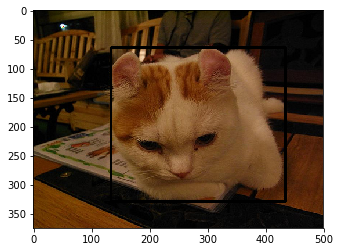

In [21]:
img_input = tf.placeholder(tf.float32, [1, None, None, 3])

# input the bbox location and the class id 
# in format x,y,w,h,classId
y_bbox_regr = tf.placeholder(tf.float32, [1, None, 4])

y_bbox_cls = tf.placeholder(tf.float32, [1, None, 1])

conv_layer,conv_end_points = vgg_16(img_input)
conv_restore_names = [ item for item in conv_end_points] 

rpn_class, rpn_regr, rpn_end_points = rpn(conv_layer,nb_anchors)
rpn_class_softmax = tf.nn.softmax(rpn_class)

generate_anchors = tf.py_func(create_generate_anchors(), [rpn_regr, img_input], tf.int32, name="generate_anchors")

# generate grounth rpn regr. truth 
rpn_ground_truth = tf.py_func(create_rpn_ground_truth, [generate_anchors, y_bbox_regr, y_bbox_cls], [tf.float32, tf.float32], name="rpn_ground_truth")


# cal result 
proposal_layer = rpn_proposal_layer(generate_anchors, rpn_regr, rpn_class_softmax)

# rpn_cls_ground_truth  = tf.py_func(cls_ground_truth,  rpn_ground_truth, tf.float32, name="rpn_cls_ground_truth")
# rpn_regr_ground_truth = tf.py_func(regr_ground_truth, rpn_ground_truth, tf.float32, name="rpn_regr_ground_truth")


rpn_cls_ground_truth  = tf.placeholder(tf.float32)
rpn_regr_ground_truth = tf.placeholder(tf.float32)


# restore weights
variables_to_restore = slim.get_variables_to_restore(include=conv_restore_names, exclude=['rpn_adam'])
vgg_checkpoint_path = os.path.join("./", 'vgg_16.ckpt')

restorer = tf.train.Saver(variables_to_restore)

rpn_loss_regr = rpn_regr_loss(rpn_regr, rpn_regr_ground_truth, rpn_cls_ground_truth)
rpn_loss_regr_mean = tf.reduce_mean(rpn_loss_regr)

rpn_loss_cls = rpn_class_loss(rpn_class, rpn_cls_ground_truth )
rpn_loss_cls_mean = tf.reduce_mean(rpn_loss_cls)

rpn_loss = rpn_loss_regr_mean + rpn_loss_cls_mean

tf.summary.scalar('rpn_loss', rpn_loss)
tf.summary.scalar('rpn_loss_cls_mean', rpn_loss_cls_mean)
tf.summary.scalar('rpn_loss_regr_mean', rpn_loss_regr_mean)

rpn_optimizer = tf.train.AdamOptimizer(0.005, name='rpn_adam').minimize(rpn_loss)

init_op = tf.global_variables_initializer()
saver = tf.train.Saver()

# get the training info 
ts = time.time()
logName = datetime.datetime.fromtimestamp(ts).strftime('%Y_%m_%d_%H_%M_%S')
if not os.path.exists('./logs/'+logName):
    os.makedirs('./logs/'+logName)
    
# tensorboard summary
merged = tf.summary.merge_all()


# define drawed rect result
raw_rect_input = [img_input, proposal_layer, y_bbox_regr]
raw_rect = tf.py_func(drawRes, raw_rect_input, tf.float32, name="raw_rect")
draw_img = tf.summary.image("draw_rpn_result", raw_rect) #, max_outputs=EPOCHES, collections=None


with tf.Session() as sess:
    # Restore variables from disk.
    restorer.restore(sess, "./vgg_16.ckpt")

    sess.run(init_op)
    print("restore conv layers")
    
    print("init tensorboard ")
    train_writer = tf.summary.FileWriter("logs/"+logName, sess.graph)  
    
    datas_source = Data_source()
    totalNbImgs = datas_source.get_total_imgs()    
    
    # epoches 
    for epoch in range(EPOCHES):
        generator = datas_source.get_generator()
        
        curImg = 1
        last_img = None
        last_xxyy = None
#       loop images in one epoch 
        for img, xywh, xxyy, cls, rpn_regr_y, rpn_cls_y  in tqdm(generator, total=totalNbImgs): 
            
            target_tensor = [rpn_optimizer, merged, proposal_layer, rpn_regr, rpn_regr_ground_truth]
            feed_dict = {
                img_input:   img,
#                 y_bbox_regr: xywh,
#                 y_bbox_cls:  cls,
                rpn_cls_ground_truth: rpn_cls_y,
                rpn_regr_ground_truth: rpn_regr_y
            }

            opt, summary, boxes, regr, regr_y = sess.run(target_tensor, feed_dict=feed_dict)
            train_writer.add_summary(summary, epoch*totalNbImgs + curImg)
            
            
            curImg+=1
            last_img = img
            last_xxyy = xxyy
            
            if curImg > 10:
                break
            
            
        summary, raw_rect_res, boxes = sess.run([draw_img, raw_rect,proposal_layer], feed_dict={img_input: last_img, y_bbox_regr:last_xxyy})
        plt.imshow((raw_rect_res[0]+0.5)*255)
        train_writer.add_summary(summary, epoch)
        
        print("Epoch "+ str(epoch))
        saver.save(sess, 'model/rpn_model',global_step=epoch)
    
tf.reset_default_graph()

In [22]:
tf.reset_default_graph()


In [23]:
raw_rect_res.shape

(1, 375, 500, 3)

In [24]:
tf.__version__

'1.1.0'

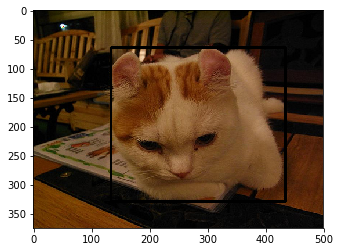

In [25]:
%matplotlib inline
plt.imshow((raw_rect_res[0]+0.5)*255)